## A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import magec_utils as mg
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### PIMA Dataset
The Pima are a group of Native Americans living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, the PIMA have undergone of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity. The Pima have been under near-constant study since 1965 due to the high incidence rate of Diabetes in PIMA females. The dataset was originally published by the National Institute of Diabetes and Digestive and Kidney Diseases, consisting of 8 diagnostic measurements pertaining to 768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. Three types of models: logistic regression, a random forest, and a deep neural network were trained on the data with two goals. First, to provide a simple dataset with which to access the fidelity of the MAGECS. Second, to directly compare any differences that these three statistical models might learn when trained on the same data!

In [3]:
pima = pd.read_csv('diabetes.csv')
seed = 7
np.random.seed(seed)
x = pima.iloc[:, 0:8]
Y = pima.iloc[:,8]

x_train, x_validation, Y_train, Y_validation = train_test_split(x, Y, test_size=0.2, random_state=seed)

stsc = StandardScaler()
xst_train = stsc.fit_transform(x_train)
xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)
xst_validation = stsc.transform(x_validation)
xst_validation = pd.DataFrame(xst_validation, index=x_validation.index, columns=x_validation.columns)

# Format
x_validation_p = xst_validation.copy()
x_validation_p['timepoint'] = 0
x_validation_p['case'] = np.arange(len(x_validation_p))
x_validation_p.set_index(['case','timepoint'], inplace=True)
x_validation_p = x_validation_p.sort_index(axis=1)

y_validation_p = pd.DataFrame(Y_validation.copy())
y_validation_p['timepoint'] = 0
y_validation_p['case'] = np.arange(len(x_validation_p))
y_validation_p.set_index(['case','timepoint'], inplace=True)
y_validation_p = y_validation_p.sort_index(axis=1)


# Format
x_train_p = xst_train.copy()
x_train_p['timepoint'] = 0
x_train_p['case'] = np.arange(len(x_train_p))
x_train_p.set_index(['case','timepoint'], inplace=True)
x_train_p = x_train_p.sort_index(axis=1)

In [4]:
# Xst = pd.concat([xst_train, xst_validation])
# Yst = pd.concat([Y_train, Y_validation])

In [5]:
x_validation.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,43,27.2,0.580,24
236,7,181,84,21,192,35.9,0.586,51
323,13,152,90,33,29,26.8,0.731,43
98,6,93,50,30,64,28.7,0.356,23
701,6,125,78,31,0,27.6,0.565,49


In [6]:
x_validation_p.head()

,,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
case,timepoint,,,,,,,,
0,0,-0.773377,-0.645827,-0.359644,0.353425,-0.927785,-0.306836,-0.848867,-0.525387
1,0,1.578677,0.472920,0.797314,0.371810,1.890014,1.062290,0.956690,0.033690
2,0,0.881772,-0.697264,1.112848,0.816093,0.992034,-0.435478,2.762247,0.779127
3,0,-0.860490,-0.452940,-0.990712,-0.332915,-0.834890,-0.113872,0.655764,0.592768
4,0,1.404451,-0.594391,0.481780,0.307465,0.155984,-0.701953,0.655764,0.654887


### MAgECs ("case" level)
Given a model and a dataset with 'scaled' (Z-normalized) features, iterate over dataset rows and features (and timepoints if dataset is a longitudinal dataset) and compute MAgEC coefficients. For a binary classification task the MAgEC coefficient for a given prediction is equal to the difference between the predicted logit probability for that datapoint and the predicted logit probability of a Z-perturbed datapoint. The latter is defined as the original datapoint with a modified feature set to 0 (mean value of scaled feature).

### Multi-Layer-Perceptron Model 

In [7]:
model = load_model('pima_model_sts.h5')

In [8]:
mlp_score = roc_auc_score(y_validation_p, model.predict(x_validation_p))
mlp_score

0.6952432627961656

In [9]:
# from functools import partial
# from keras.wrappers.scikit_learn import KerasClassifier
# def pima_keras(model):
#     return model
# pima_keras = KerasClassifier(partial(pima_keras, model), verbose=0, batch_size=16)

In [10]:
# mg.model_performance(pima_keras, Xst, Yst, 'MLP')

In [11]:
case_mlp = mg.case_magecs(model, x_validation_p, model_name='mlp')

In [12]:
features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

In [13]:
# use all feature to normalize MAgECS
magecs_mlp = mg.normalize_magecs(case_mlp, features=None, model_name='mlp')

In [14]:
magecs_mlp.head(3)

features,case,timepoint,mlp_Age,mlp_BMI,mlp_BloodPressure,mlp_DiabetesPedigreeFunction,mlp_Glucose,mlp_Insulin,mlp_Pregnancies,mlp_SkinThickness,perturb_Age_prob_mlp,orig_prob_mlp,perturb_BMI_prob_mlp,perturb_BloodPressure_prob_mlp,perturb_DiabetesPedigreeFunction_prob_mlp,perturb_Glucose_prob_mlp,perturb_Insulin_prob_mlp,perturb_Pregnancies_prob_mlp,perturb_SkinThickness_prob_mlp
0,0,0,0.249736,0.718566,-0.037057,0.006918,-0.025844,0.233703,0.520776,0.305584,0.081521,0.063786,0.127258,0.061483,0.064225,0.062171,0.080258,0.105754,0.086059
1,1,0,-0.782240,-0.420515,0.112158,-0.095649,0.194162,-0.251709,-0.297298,-0.009868,0.521750,0.744293,0.632011,0.770142,0.720795,0.787846,0.679751,0.667174,0.741930
2,2,0,-0.280346,0.386273,0.157763,-0.229775,0.030192,0.060988,-0.814133,-0.164530,0.464860,0.591666,0.745703,0.658987,0.487878,0.604908,0.618258,0.246943,0.517638


In [15]:
np.linalg.norm([0.249736,0.718566,-0.037057,0.006919,-0.025843,0.233703,0.520776,0.305584])

1.0000002179759764

In [16]:
magecs_mlp = magecs_mlp.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [17]:
# mg.plot_all_violin(magecs_mlp, features=features, model_name='mlp')

### Random Forest (calibrated)

In [18]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train_p, Y_train)
sigmoidRF = CalibratedClassifierCV(RandomForestClassifier(n_estimators=1000), cv=5, method='sigmoid')
sigmoidRF.fit(x_train_p, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='sigmoid')

In [19]:
case_rf = mg.case_magecs(sigmoidRF, x_validation_p, model_name='rf')
magecs_rf = mg.normalize_magecs(case_rf, features=None, model_name='rf')
magecs_rf = magecs_rf.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# mg.plot_all_violin(magecs_rf, features=features, model_name='rf')

In [20]:
rf_score = roc_auc_score(y_validation_p, sigmoidRF.predict(x_validation_p))
rf_score

0.7518538614577681

In [21]:
# mg.model_performance(sigmoidRF, Xst, Yst, 'RF')

### Logistic Regression

In [22]:
lr = LogisticRegression(C=1.)
lr.fit(x_train_p, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
lr_score = roc_auc_score(y_validation_p, lr.predict(x_validation_p))
lr_score

0.739464640983903

In [24]:
case_lr = mg.case_magecs(lr, x_validation_p, model_name='lr')
magecs_lr = mg.normalize_magecs(case_lr, features=None, model_name='lr')
magecs_lr = magecs_lr.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# mg.plot_all_violin(magecs_lr, features=features, model_name='lr')

## MAgEC Consensus

In [25]:
joined = mg.magec_models(magecs_mlp, 
                         magecs_rf, 
                         magecs_lr, 
                         Xdata=x_validation_p, 
                         Ydata=y_validation_p, 
                         features=['Age', 'BloodPressure', 'BMI', 'Glucose', 'Insulin',
                                      'SkinThickness', 'DiabetesPedigreeFunction'])

In [26]:
joined.head(3)

,case,timepoint,mlp_Age,mlp_BMI,mlp_BloodPressure,mlp_DiabetesPedigreeFunction,mlp_Glucose,mlp_Insulin,mlp_SkinThickness,perturb_Age_prob_mlp,...,lr_Insulin,lr_SkinThickness,perturb_Age_prob_lr,perturb_BMI_prob_lr,perturb_BloodPressure_prob_lr,perturb_DiabetesPedigreeFunction_prob_lr,perturb_Glucose_prob_lr,perturb_Insulin_prob_lr,perturb_SkinThickness_prob_lr,orig_prob_lr
0,0,0,0.249736,0.718566,-0.037057,0.006918,-0.025844,0.233703,0.305584,0.081521,...,-0.036688,0.015571,0.079574,0.112591,0.066757,0.063725,0.171329,0.069739,0.073770,0.072547
1,1,0,-0.782240,-0.420515,0.112158,-0.095649,0.194162,-0.251709,-0.009868,0.521750,...,0.070729,-0.000556,0.837343,0.815877,0.885038,0.845075,0.465754,0.879739,0.863147,0.863284
2,2,0,-0.280346,0.386273,0.157763,-0.229775,0.030192,0.060988,-0.164530,0.464860,...,-0.035675,-0.015821,0.710667,0.822721,0.784033,0.666296,0.493356,0.721596,0.728289,0.733549


In [27]:
# use AUC scores as weights
weights = {'mlp': mlp_score, 'rf': rf_score, 'lr': lr_score}

### MAgEC individual examples

In [28]:
joined.iloc[2]

case                                         2.000000
timepoint                                    0.000000
mlp_Age                                     -0.280346
mlp_BMI                                      0.386273
mlp_BloodPressure                            0.157763
mlp_DiabetesPedigreeFunction                -0.229775
mlp_Glucose                                  0.030192
mlp_Insulin                                  0.060988
mlp_SkinThickness                           -0.164530
perturb_Age_prob_mlp                         0.464860
perturb_BMI_prob_mlp                         0.745703
perturb_BloodPressure_prob_mlp               0.658987
perturb_DiabetesPedigreeFunction_prob_mlp    0.487878
perturb_Glucose_prob_mlp                     0.604908
perturb_Insulin_prob_mlp                     0.618258
perturb_SkinThickness_prob_mlp               0.517638
orig_prob_mlp                                0.591666
Age                                          0.881772
BMI                         

## MAgEC Policy

### Ranked MAgECs (rank=1)

In [29]:
# ranks1 = mg.magec_rank(joined, rank=1, features=features)
# compute ranked MAgECs
# ranks1 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=1, features=features)
ranks1 = mg.magec_rank(joined, rank=1, features=features)

In [30]:
ranks1.head(3)

,case,timepoint,Outcome,mlp_magec,mlp_feat,rf_magec,rf_feat,lr_magec,lr_feat,perturb_BloodPressure_prob_mlp,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,0,0,0,-0.037057,BloodPressure,-0.078988,SkinThickness,-0.077178,BloodPressure,0.061483,...,0.081861,0.073770,0.063786,0.085829,0.072547,-0.359644,-0.645827,-0.927785,-0.306836,-0.525387
1,1,0,1,-0.420515,BMI,-0.958529,Glucose,-0.951876,Glucose,0.770142,...,0.849998,0.863147,0.744293,0.850585,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
2,2,0,1,-0.164530,SkinThickness,-0.282895,Glucose,-0.614731,Glucose,0.658987,...,0.473091,0.728289,0.591666,0.493407,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127


In [31]:
mg.print_ranks_stats(ranks1)

	 mlp MAgEC Stats
**** mlp_feat ****
BMI              40
Insulin          38
SkinThickness    24
BloodPressure    22
Glucose          17
not_found        13
Name: mlp_feat, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat ****
Glucose          56
Insulin          47
BloodPressure    25
SkinThickness    23
BMI               2
not_found         1
Name: rf_feat, dtype: int64
***********
	 lr MAgEC Stats
**** lr_feat ****
Glucose          63
Insulin          31
BMI              31
BloodPressure    26
not_found         2
SkinThickness     1
Name: lr_feat, dtype: int64
***********


### Consensus using rank=1 and 'sum' policy

In [32]:
consensus1a = mg.magec_consensus(ranks1, use_weights=True, weights=weights)

In [33]:
consensus1a.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,BloodPressure,0.082834,2,"[lr, mlp]",5.796109,4.856736
1,1,0,Glucose,1.424552,2,"[lr, rf]",38.104730,23.452655
2,2,0,Glucose,0.667268,2,"[lr, rf]",27.547160,17.618737


In [34]:
consensus1a.winner.value_counts()

Glucose          53
Insulin          39
BMI              24
BloodPressure    23
SkinThickness    15
Name: winner, dtype: int64

In [35]:
consensus1a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            1.004380  0.352818    24  2.041667  0.358641    24
BloodPressure  0.380406  0.350086    23  1.913043  0.792754    23
Glucose        0.951578  0.430154    53  1.924528  0.384760    53
Insulin        0.439026  0.305643    39  1.692308  0.467572    39
SkinThickness  0.500764  0.277151    15  1.600000  0.507093    15

### Consensus using rank=1 and 'mean' policy

In [36]:
consensus1b = mg.magec_consensus(ranks1, use_weights=True, weights=weights, policy='mean')

In [37]:
consensus1b.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,SkinThickness,0.059388,1,[rf],4.623407,-10.660321
1,1,0,Glucose,0.712276,2,"[lr, rf]",38.104730,23.452655
2,2,0,Glucose,0.333634,2,"[lr, rf]",27.547160,17.618737


In [38]:
consensus1b.winner.value_counts()

Glucose          48
Insulin          44
BMI              25
SkinThickness    20
BloodPressure    17
Name: winner, dtype: int64

In [39]:
consensus1b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            0.497463  0.130257    25  1.960000  0.454606    25
BloodPressure  0.170682  0.118618    17  1.882353  0.927520    17
Glucose        0.508872  0.204485    48  1.854167  0.460785    48
Insulin        0.308372  0.205708    44  1.522727  0.505258    44
SkinThickness  0.280911  0.142562    20  1.450000  0.510418    20

### Ranked MAgECs (rank=3)

In [40]:
# ranks3 = mg.magec_rank(joined, rank=3)
# ranks3 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=3, features=features)
ranks3 = mg.magec_rank(joined, rank=3, features=features)

In [41]:
ranks3.head()

,case,timepoint,Outcome,mlp_magec_3,mlp_feat_3,mlp_magec_2,mlp_feat_2,mlp_magec_1,mlp_feat_1,rf_magec_3,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,0,0,0,NaN,not_found,-0.025844,Glucose,-0.037057,BloodPressure,-0.032573,...,0.081861,0.073770,0.063786,0.085829,0.072547,-0.359644,-0.645827,-0.927785,-0.306836,-0.525387
1,1,0,1,-0.009868,SkinThickness,-0.251709,Insulin,-0.420515,BMI,-0.124540,...,0.849998,0.863147,0.744293,0.850585,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
2,2,0,1,NaN,not_found,NaN,not_found,-0.164530,SkinThickness,-0.051160,...,0.473091,0.728289,0.591666,0.493407,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127
3,3,0,0,-0.350918,BloodPressure,-0.402479,Glucose,-0.567668,SkinThickness,-0.012398,...,0.114262,0.139840,0.326575,0.137435,0.142306,-0.990712,-0.452940,-0.834890,-0.113872,0.592768
4,4,0,1,-0.000797,Glucose,-0.038680,BloodPressure,-0.054893,SkinThickness,-0.010401,...,0.471435,0.348880,0.355166,0.490020,0.354004,0.481780,-0.594391,0.155984,-0.701953,0.654887


In [42]:
mg.print_ranks_stats(ranks3)

	 mlp MAgEC Stats
**** mlp_feat_3 ****
not_found        92
SkinThickness    22
Glucose          18
BloodPressure    14
BMI               6
Insulin           2
Name: mlp_feat_3, dtype: int64
***********
**** mlp_feat_2 ****
not_found        36
Glucose          31
SkinThickness    27
BloodPressure    24
Insulin          20
BMI              16
Name: mlp_feat_2, dtype: int64
***********
**** mlp_feat_1 ****
BMI              40
Insulin          38
SkinThickness    24
BloodPressure    22
Glucose          17
not_found        13
Name: mlp_feat_1, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat_3 ****
not_found        45
SkinThickness    36
Insulin          30
BloodPressure    29
BMI               8
Glucose           6
Name: rf_feat_3, dtype: int64
***********
**** rf_feat_2 ****
Insulin          50
SkinThickness    50
BloodPressure    25
BMI              13
Glucose           9
not_found         7
Name: rf_feat_2, dtype: int64
***********
**** rf_feat_1 ****
Glucose          56
Insulin  

### Consensus using rank=3 and 'sum' policy

In [43]:
consensus3a = mg.magec_consensus(ranks3, use_weights=True, weights=weights)

In [44]:
consensus3a.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,BloodPressure,0.120792,3,"[lr, mlp, rf]",4.856736,4.856736
1,1,0,Glucose,1.424552,2,"[lr, rf]",38.104730,23.452655
2,2,0,Glucose,0.667268,2,"[lr, rf]",27.547160,17.618737
3,3,0,BloodPressure,0.642625,3,"[lr, mlp, rf]",19.966387,19.966387
4,4,0,Insulin,0.420519,2,"[lr, rf]",13.554333,-2.986308


In [45]:
consensus3a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            1.070824  0.368532    26  2.423077  0.503831    26
BloodPressure  0.444019  0.392067    23  2.347826  0.831685    23
Glucose        1.015697  0.395812    50  2.180000  0.481918    50
Insulin        0.418663  0.309904    40  1.925000  0.266747    40
SkinThickness  0.556259  0.280193    15  2.666667  0.723747    15

In [46]:
consensus3a.winner.value_counts()

Glucose          50
Insulin          40
BMI              26
BloodPressure    23
SkinThickness    15
Name: winner, dtype: int64

### Consensus using rank=3 and 'mean' policy

In [47]:
consensus3b = mg.magec_consensus(ranks3, use_weights=True, weights=weights, policy='mean')

In [48]:
consensus3b.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,SkinThickness,0.059388,1,[rf],4.623407,-10.660321
1,1,0,Glucose,0.712276,2,"[lr, rf]",38.104730,23.452655
2,2,0,Glucose,0.333634,2,"[lr, rf]",27.547160,17.618737
3,3,0,Glucose,0.279821,1,[mlp],26.383353,-42.800964
4,4,0,Insulin,0.210259,2,"[lr, rf]",13.554333,-2.986308


In [49]:
consensus3b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            0.455528  0.129316    25  2.400000  0.500000    25
BloodPressure  0.191508  0.117062    17  2.000000  1.000000    17
Glucose        0.452885  0.209837    53  2.037736  0.587114    53
Insulin        0.254010  0.174743    45  1.777778  0.420437    45
SkinThickness  0.196382  0.103852    14  2.285714  0.994490    14

In [50]:
consensus3b.winner.value_counts()

Glucose          53
Insulin          45
BMI              25
BloodPressure    17
SkinThickness    14
Name: winner, dtype: int64

### MAgEC Bar Plot

In [51]:
def ranked_stats(ranks):
    columns = ranks.columns
    stats = {}
    for model in ['lr', 'rf', 'mlp']:
        cols = [col for col in columns if col.startswith(model + '_' + 'feat')]
        if len(cols):
            for col in cols:
                tmp = ranks[col].value_counts()
                for z in zip(tmp.index.values.tolist(), tmp.values.tolist()):
                    if z[0] in stats:
                        stats[z[0]].append((z[1], model))
                    else:
                        stats[z[0]] = [(z[1], model)]
    return stats


def con_stats(consensus, label='CON@1'):
    conf = consensus.winner.value_counts().index.values.tolist()
    conv = consensus.winner.value_counts().values.tolist()
    con = {z[0]:(z[1],label) for z in zip(conf, conv)}
    return con


def df_stats(stats, con1, con3):
    dfplot = pd.DataFrame(columns=['Feature', 'LR', 'RF', 'MLP', 'CON@1', 'CON@3'], 
                          data=[['Glucose',
                                 stats['Glucose'][0][0],
                                 stats['Glucose'][1][0],
                                 stats['Glucose'][2][0], 
                                 con1['Glucose'][0],
                                 con3['Glucose'][0]],
                                ['Insulin',
                                 stats['Insulin'][0][0],
                                 stats['Insulin'][1][0],
                                 stats['Insulin'][2][0], 
                                 con1['Insulin'][0],
                                 con3['Insulin'][0]],
                                ['BMI',
                                 stats['BMI'][0][0],
                                 stats['BMI'][1][0],
                                 stats['BMI'][2][0], 
                                 con1['BMI'][0],
                                 con3['BMI'][0]],
                                ['BloodPressure',
                                 stats['BloodPressure'][0][0],
                                 stats['BloodPressure'][1][0],
                                 stats['BloodPressure'][2][0], 
                                 con1['BloodPressure'][0],
                                 con3['BloodPressure'][0]],
                                ['SkinThickness',
                                 stats['SkinThickness'][0][0],
                                 stats['SkinThickness'][1][0],
                                 stats['SkinThickness'][2][0], 
                                 con1['SkinThickness'][0],
                                 con3['SkinThickness'][0]],
                                ['not_found',
                                 stats['not_found'][0][0],
                                 stats['not_found'][1][0],
                                 stats['not_found'][2][0],
                                 0,
                                 0]])
    return dfplot


def plot_stats(dfplot, save=False):
    dfplot = dfplot.set_index('Feature')
    dfplot.plot(kind='bar', 
            stacked=True, 
            figsize=(10,6), 
            title='MAgEC (best) features by model and policy', 
            rot=45)
    if save:
        plt.savefig('pima_magec_stats.png', bbox_inches='tight')
    return

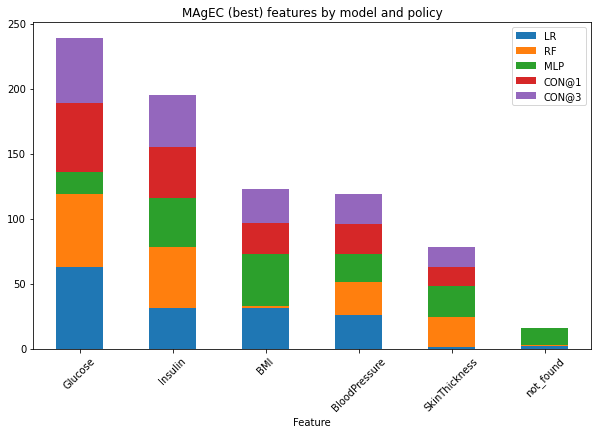

In [52]:
stats = ranked_stats(ranks1)
con1 = con_stats(consensus1a)
con3 = con_stats(consensus3a, label='CON@3')
dfplot = df_stats(stats, con1, con3)
plot_stats(dfplot, True)

## MAgEC individual 'case'

In [53]:
case = 47

In [54]:
ranks1[ranks1['case'] == case].iloc[0]

case                                    47
timepoint                                0
Outcome                                  1
mlp_magec                         -0.89437
mlp_feat                           Insulin
rf_magec                         -0.570153
rf_feat                            Insulin
lr_magec                         -0.648005
lr_feat                            Glucose
perturb_BloodPressure_prob_mlp    0.753379
perturb_BloodPressure_prob_rf      0.51382
perturb_BloodPressure_prob_lr     0.319419
perturb_BMI_prob_mlp              0.716757
perturb_BMI_prob_rf               0.511948
perturb_BMI_prob_lr               0.297848
perturb_Glucose_prob_mlp          0.709918
perturb_Glucose_prob_rf           0.421574
perturb_Glucose_prob_lr           0.148306
perturb_Insulin_prob_mlp          0.356204
perturb_Insulin_prob_rf           0.415723
perturb_Insulin_prob_lr           0.372988
perturb_SkinThickness_prob_mlp    0.659232
perturb_SkinThickness_prob_rf      0.50973
perturb_Ski

In [55]:
ranks3[ranks3['case'] == case].iloc[0]

case                                         47
timepoint                                     0
Outcome                                       1
mlp_magec_3                                 NaN
mlp_feat_3                            not_found
mlp_magec_2                          -0.0632291
mlp_feat_2                        SkinThickness
mlp_magec_1                            -0.89437
mlp_feat_1                              Insulin
rf_magec_3                           -0.0817596
rf_feat_3                         SkinThickness
rf_magec_2                            -0.539193
rf_feat_2                               Glucose
rf_magec_1                            -0.570153
rf_feat_1                               Insulin
lr_magec_3                                  NaN
lr_feat_3                             not_found
lr_magec_2                          -0.00684746
lr_feat_2                         SkinThickness
lr_magec_1                            -0.648005
lr_feat_1                               

In [56]:
consensus1a[consensus1a['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Insulin,1.050476,2,"[mlp, rf]",34.270883,8.81529


In [57]:
consensus1b[consensus1b['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Insulin,0.525238,2,"[mlp, rf]",34.270883,8.81529


In [58]:
consensus3a[consensus3a['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Insulin,1.050476,2,"[mlp, rf]",34.270883,8.81529


In [59]:
consensus3b[consensus3b['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Insulin,0.525238,2,"[mlp, rf]",34.270883,8.81529


### MAgEC correlations

In [60]:
corr = joined[joined.columns[2:]].corr()

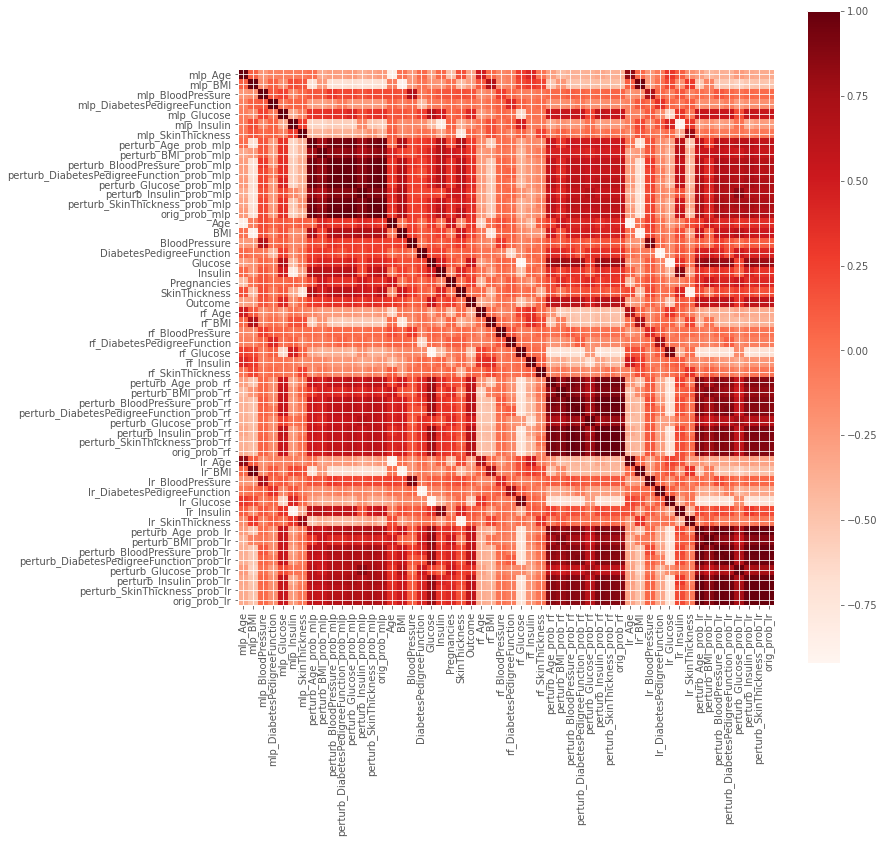

In [61]:
plt.figure(figsize=[12,12])
plt.style.use('ggplot')
plt.imshow(corr, cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(joined.columns[2:]))]
plt.xticks(tick_marks, joined.columns[2:], rotation='vertical')
plt.yticks(tick_marks, joined.columns[2:]);

## MAgECs population similarity

In [62]:
sim_mlp = mg.magec_similarity(magecs_mlp, x_validation_p, model_name='mlp')
sim_rf = mg.magec_similarity(magecs_rf, x_validation_p, model_name='rf')
sim_lr = mg.magec_similarity(magecs_lr, x_validation_p, model_name='lr')

In [63]:
print("Top Absolute Correlationsin in MLP model")
print(mg.get_top_abs_correlations(sim_mlp, 10))

Top Absolute Correlationsin in MLP model
mlp_BMI            BMI              0.862294
mlp_Insulin        Insulin          0.797427
mlp_SkinThickness  SkinThickness    0.730571
mlp_BloodPressure  BloodPressure    0.659626
mlp_Glucose        Glucose          0.653958
Glucose            Outcome          0.544038
BMI                SkinThickness    0.509936
Glucose            Insulin          0.470695
mlp_Glucose        Insulin          0.468632
mlp_BMI            SkinThickness    0.444827
dtype: float64


In [64]:
print("Top Absolute Correlationsin in RF model")
print(mg.get_top_abs_correlations(sim_rf, 5))

Top Absolute Correlationsin in RF model
rf_Glucose                   Glucose                     0.922416
rf_BMI                       BMI                         0.728756
rf_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.614637
Glucose                      Outcome                     0.544038
rf_Glucose                   Outcome                     0.511843
dtype: float64


In [65]:
print("Top Absolute Correlationsin LR model")
print(mg.get_top_abs_correlations(sim_lr, 5))

Top Absolute Correlationsin LR model
lr_Glucose                   Glucose                     0.921184
lr_BloodPressure             BloodPressure               0.895361
lr_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.892023
lr_SkinThickness             SkinThickness               0.871342
lr_BMI                       BMI                         0.871290
dtype: float64


### PIMA Exploratory Data Analysis (EDA)

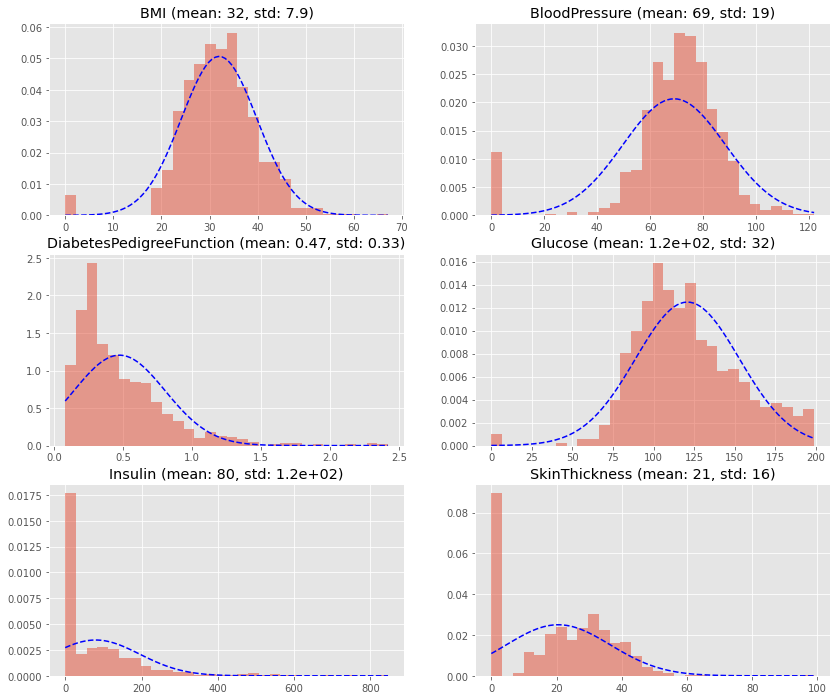

In [66]:
mg.plot_pima_features(pima);

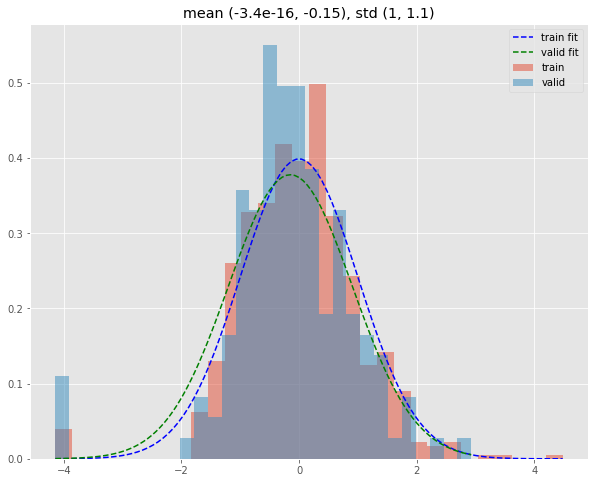

In [67]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BMI')

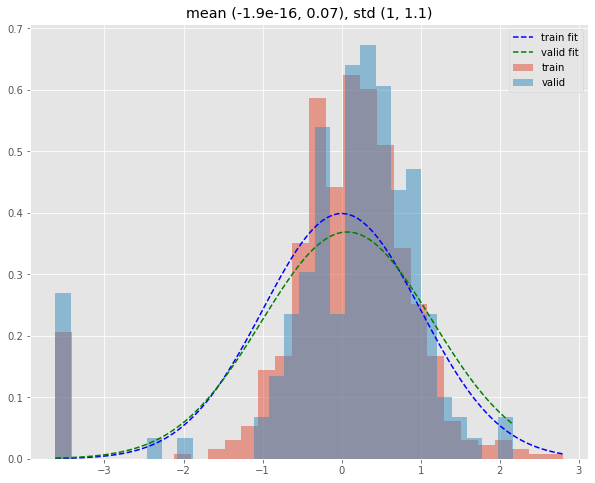

In [68]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BloodPressure')

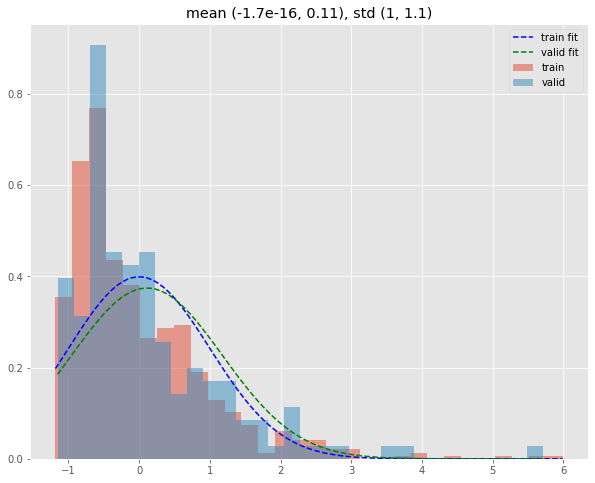

In [69]:
mg.plot_train_valid(x_train_p, x_validation_p, 'DiabetesPedigreeFunction')

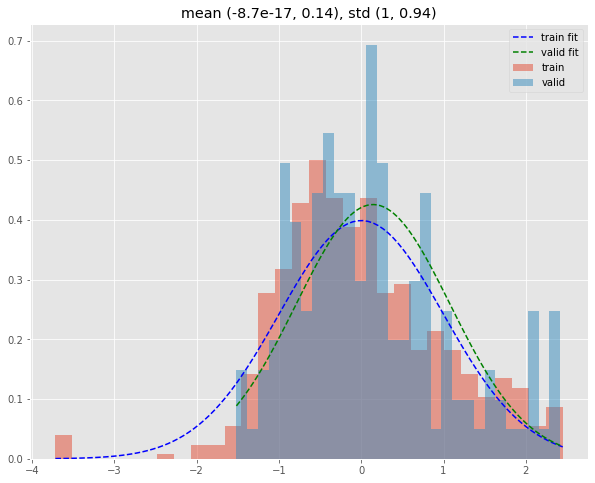

In [70]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Glucose')

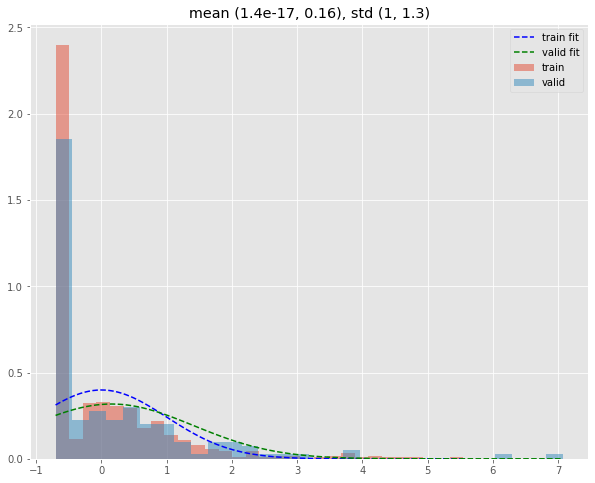

In [71]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Insulin')

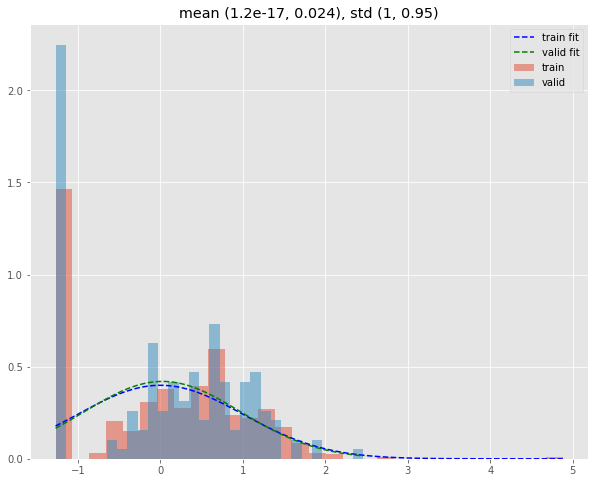

In [72]:
mg.plot_train_valid(x_train_p, x_validation_p, 'SkinThickness')